# Revenue Forecast for Online Gaming Platform

This notebook simulates monthly deposits and churn for a fictional online gaming platform and fits a Holt-Winters exponential smoothing model to forecast net revenue for the next quarter.

In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8-whitegrid')
np.random.seed(42)

In [3]:
# Generate 24 months of synthetic deposits and churn rates
dates = pd.date_range('2022-01-01', periods=24, freq='MS')
base_deposits = 120000 + np.linspace(0, 15000, len(dates))
seasonality = 8000 * np.sin(np.arange(len(dates)) * np.pi / 6)
noise = np.random.normal(0, 5000, len(dates))
deposits = base_deposits + seasonality + noise

churn_base = 0.18 - np.linspace(0, 0.03, len(dates))
churn_noise = np.random.normal(0, 0.01, len(dates))
churn_rate = np.clip(churn_base + churn_noise, 0.05, 0.35)

net_revenue = deposits * (1 - churn_rate)

df = pd.DataFrame({
    'month': dates,
    'deposits': deposits,
    'churn_rate': churn_rate,
    'net_revenue': net_revenue,
})

df.head()

,month,deposits,churn_rate,net_revenue
0,2022-01-01,122483.570765,0.174556,101103.307427
1,2022-02-01,123960.852407,0.179805,101672.086455
2,2022-03-01,131470.993747,0.165881,109662.405376
3,2022-04-01,137571.671021,0.179844,112830.240126
4,2022-05-01,128366.132009,0.168776,106700.981242


In [4]:
# Fit additive Holt-Winters exponential smoothing and forecast next 3 months
model = ExponentialSmoothing(
    df['net_revenue'],
    trend='add',
    seasonal='add',
    seasonal_periods=12
)
fit = model.fit()
forecast = fit.forecast(3)

forecast_index = pd.date_range(df['month'].iloc[-1] + pd.offsets.MonthBegin(), periods=3, freq='MS')
forecast_df = pd.DataFrame({
    'month': forecast_index,
    'deposits': [np.nan] * 3,
    'churn_rate': [np.nan] * 3,
    'net_revenue': forecast.values,
})

combined_df = pd.concat([df, forecast_df], ignore_index=True)
combined_df.tail()

,month,deposits,churn_rate,net_revenue
22,2023-11-01,127757.263880,0.146698,109015.533879
23,2023-12-01,123876.259069,0.160571,103985.296741
24,2024-01-01,NaN,NaN,112261.017722
25,2024-02-01,NaN,NaN,110272.477839
26,2024-03-01,NaN,NaN,112925.353778


In [5]:
# Export combined historical and forecasted data
output_path = Path('../data/synthetic_revenue_data.csv')
combined_df.to_csv(output_path, index=False)
output_path.resolve()

PosixPath('/Users/den/Desktop/analytics-portfolio/revenue_forecast_model/data/synthetic_revenue_data.csv')

PosixPath('/Users/den/Desktop/analytics-portfolio/revenue_forecast_model/reports/revenue_forecast_chart.png')

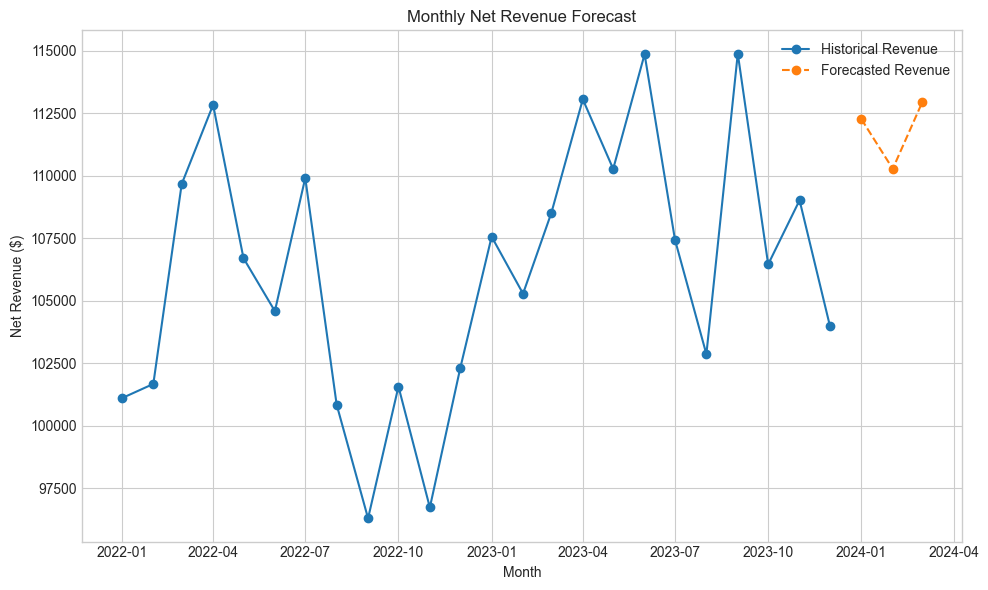

In [6]:
# Plot historical vs. forecasted net revenue
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(df['month'], df['net_revenue'], marker='o', label='Historical Revenue')
ax.plot(forecast_index, forecast, marker='o', linestyle='--', label='Forecasted Revenue')
ax.set_title('Monthly Net Revenue Forecast')
ax.set_xlabel('Month')
ax.set_ylabel('Net Revenue ($)')
ax.legend()
fig.tight_layout()

chart_path = Path('../reports/revenue_forecast_chart.png')
fig.savefig(chart_path, dpi=300)
chart_path.resolve()

In [7]:
# Console summary metrics
historical_total = df['net_revenue'].sum()
next_quarter_total = forecast.sum()

slope = np.polyfit(np.arange(len(df)), df['churn_rate'], 1)[0]
if slope > 0.001:
    churn_trend = 'increasing'
elif slope < -0.001:
    churn_trend = 'decreasing'
else:
    churn_trend = 'stable'

print(f'Total historical revenue: ${historical_total:,.2f}')
print(f'Forecasted next-quarter revenue: ${next_quarter_total:,.2f}')
print(f'Churn trend: {churn_trend}')

Total historical revenue: $2,548,366.45
Forecasted next-quarter revenue: $335,458.85
Churn trend: decreasing
